<a href="https://colab.research.google.com/github/KacperHaras/Delivery_Time_Predictions_DA_project/blob/main/Kacper_Haras_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

In [174]:
orders = pd.read_csv('orders.csv')
orders_products = pd.read_csv('orders_products.csv')
products = pd.read_csv('products.csv')
route_segments = pd.read_csv('route_segments.csv')

Data processing with knowledge from the analysis done in the '_analisys' file:

In [185]:
route_segments['segment_end_time'] = pd.to_datetime(route_segments['segment_end_time'])
route_segments['segment_start_time'] = pd.to_datetime(route_segments['segment_start_time'])
route_segments['segment_duration'] = (route_segments.loc[:, 'segment_end_time'] - route_segments.loc[:, 'segment_start_time']).dt.total_seconds().astype(int)
route_segments['segment_duration_minutes'] = route_segments.loc[:, 'segment_duration'] / 60

index_to_drop = route_segments[route_segments['segment_duration'] == 0].index
route_segments.drop(index=index_to_drop, inplace=True)
index_to_drop = route_segments[route_segments['segment_duration_minutes'] > 50].index
route_segments.drop(index=index_to_drop, inplace=True)

Creating merged data frame to to easily notice correlations between our values:


In [192]:
merged_df = pd.merge(orders, route_segments, on='order_id')
merged_df = pd.merge(merged_df, orders_products, on='order_id')
merged_df = pd.merge(merged_df, products, on='product_id')

A correlation map helps to visualize which columns may be important:


<Axes: >

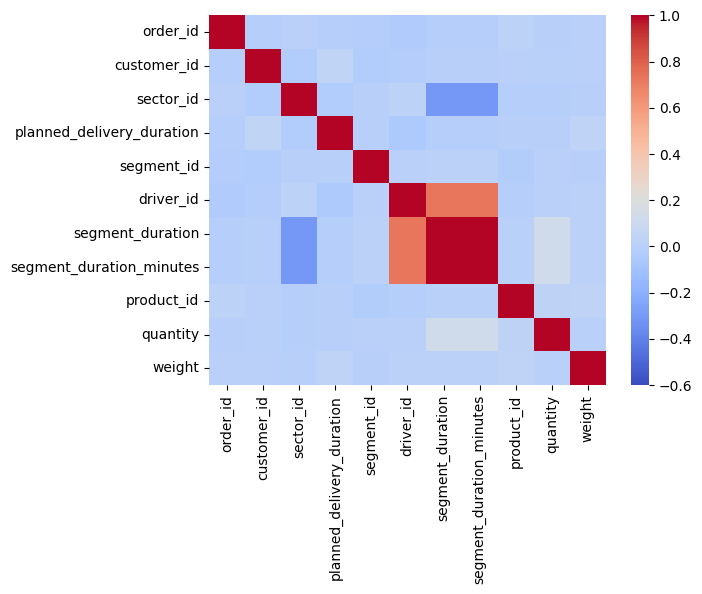

In [193]:
sns.heatmap(merged_df.corr(numeric_only=True), vmin=-0.6, vmax=1, cmap="coolwarm")

**Model of regresion:**

In [194]:
cols = ['sector_id', 'driver_id', 'quantity']

X = sm.add_constant(merged_df[cols])
y = merged_df["segment_duration"]

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       segment_duration   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     3971.
Date:                Sun, 07 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:48:04   Log-Likelihood:                -36239.
No. Observations:                6364   AIC:                         7.249e+04
Df Residuals:                    6360   BIC:                         7.251e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.0423      3.799     16.331      0.000      54.595      69.489
sector_id    -48.3140      1.096    -44.076      0.000     -50.463     -46.165
driver_id     79.6704      0.800     99.537      0.000      78.101      81.239
quantity      16.8367      1.099     15.321      0.000      14.682      18.991
==============================================================================
Omnibus:                     1636.232   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29181.697
Skew:                          -0.766   Prob(JB):                         0.00
Kurtosis:                      13.378   Cond. No.                         17.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*Sumary*:  
* The R-squared value of 0.652 means that our model explains approximately 65% of the variability in delivery times.
* The high value of the F-statistic (3971) and the very low Prob (F-statistic) (almost 0) tell us that new model does a significantly better job than a simple model that would just guess the average value of delivery time.
* A Durbin-Watson score close to 2 means that there is almost no difference between the model errors in subsequent observations


<Axes: ylabel='None'>

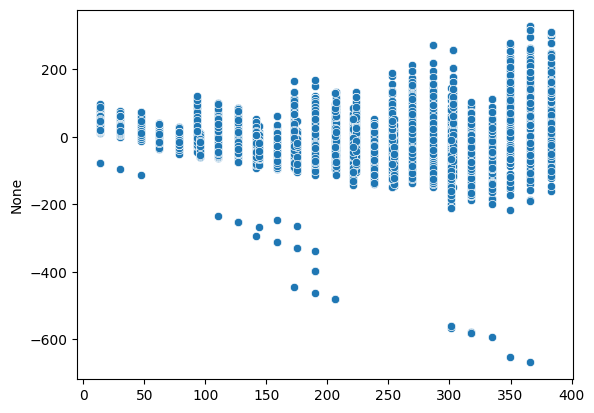

In [181]:
sns.scatterplot(x=model.predict(), y=model.resid)

Some of the residuals are away from zero on the graph, but most of the results are around zero

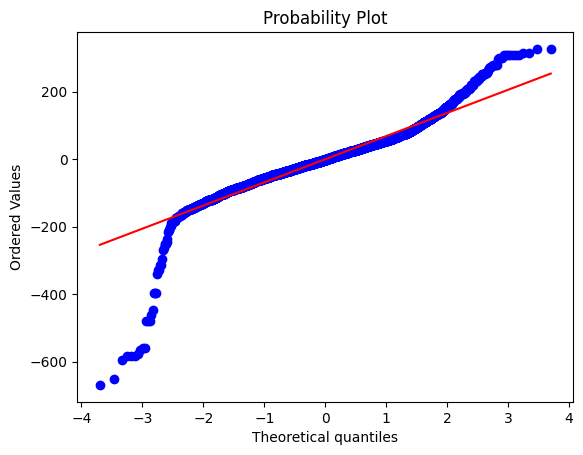

In [182]:
import scipy.stats as stats
stats.probplot(model.resid, dist="norm", plot=plt);

This plot shows how my residuals are comparing to normal distribution. I can see that most of middle values are close to red line, which means they are close to normal distribution. There are some isues with more extreme points but most of our residuals are in normal distribution.

In [183]:
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df["cooks_d"].sort_values(ascending=False).head()

5640    0.019399
517     0.015066
5807    0.011339
2231    0.010521
1419    0.010336
Name: cooks_d, dtype: float64

Cooks distance is below 0.5, what means there are not influential data points.

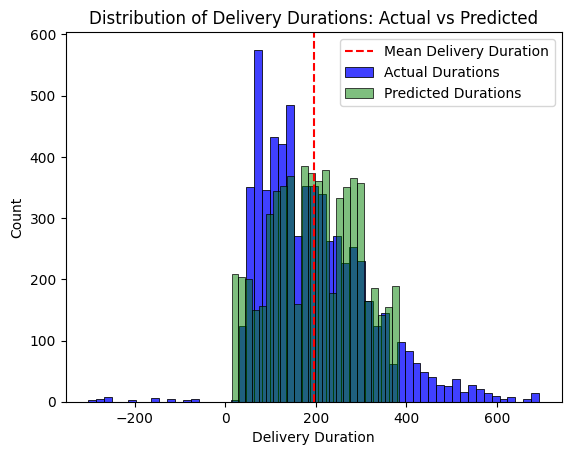

In [198]:
y_pred = model.predict(X)
mean_delivery_duration = y.mean()

sns.histplot(y, color='blue', label='Actual Durations')
sns.histplot(y_pred, color='green', label='Predicted Durations', alpha=0.5)
plt.axvline(x=mean_delivery_duration, color='red', linestyle='--', label='Mean Delivery Duration')

plt.xlabel('Delivery Duration')
plt.title('Distribution of Delivery Durations: Actual vs Predicted')
plt.legend()

plt.show()

**SUMMARY**

I created a model to predict the delivery length of a given segment by performing linear regression using the Ordinary Least Squares method. the columns that were used to create the final linear regression are: sector_id, driver_id, quantity. Using other columns did not improve or even made the result worse.

Values of R-squared, F-statistic or Durbin-Watson tell us that new model does a significantly better job than a simple model that would just guess the average value for everyone.


The reasons why deliveries can take more time due to:
* difficult place to park the vehicle
* worse driving conditions in the city center
* weather conditions
* driver experience

Additional data would be worth collecting for future analysis:
* traffic information
* weather information
* more information about the type of apartment/house

The risk of underestimtion of the delivery time may be associated with customer dissatisfaction or extension of the driver's work and also higher costs for drivers salary.

On the other hand overestimtion of the delivery time can cause a misunderstanding with the customer expectation of the arrival time and a smaller number of delivered orders during the driver's work.

